<a href="https://colab.research.google.com/github/replicable/ai-reg/blob/main/LM_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai

In [ ]:
!pip install sentence-transformers

In [3]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [4]:
import openai, gensim.downloader as api, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from gensim.models import KeyedVectors
from scipy import spatial
openai.api_key = "..."
sns.set_context('paper')
sns.set(font_scale=1)

In [5]:
glove = api.load("glove-wiki-gigaword-300")

In [6]:
adj = ['emotional', 'smart', 'cool', 'hysterical', 'married', 'rational', 'poor', 
      'reliable', 'brave', 'strong', 'cute', 'handsome', 'successful']
prof = ['doctor', 'nurse', 'lawyer', 'secretary', 'soldier',  'professor', 'scholar',
      'engineer', 'programmer', 'director', 'chef', 'homemaker', 'babysitter']
words_dt = {'adjective': adj, 'profession': prof}
key = ['he', 'she']

In [7]:
glv = dict()
for k_w, words in words_dt.items():
  results = [glove.similarity(word, key[0]) - glove.similarity(word, key[1]) for word in words]
  glv[k_w] = pd.DataFrame(data = {'word': words, 'result': results})

In [8]:
bert = dict()
for k_w, words in words_dt.items():
  results = list()
  for word in words:
    embedding_1 = model.encode(word, convert_to_tensor=True)
    embedding_2 = model.encode(key[0], convert_to_tensor=True)
    embedding_3 = model.encode(key[1], convert_to_tensor=True)
    results.append(float(util.pytorch_cos_sim(embedding_1, embedding_2) - util.pytorch_cos_sim(embedding_1, embedding_3)))
  bert[k_w] = pd.DataFrame(data = {'word': words, 'result': results})

In [9]:
gpt= dict()
for k_w, words in words_dt.items():
  results = list()
  for word in words:
    resp = openai.Embedding.create(input=[word, key[0]], engine="text-similarity-davinci-001")
    similarity0 = 1 - spatial.distance.cosine(resp['data'][0]['embedding'], resp['data'][1]['embedding'])
    resp = openai.Embedding.create(input=[word, key[1]], engine="text-similarity-davinci-001")
    similarity1 = 1 - spatial.distance.cosine(resp['data'][0]['embedding'], resp['data'][1]['embedding'])
    results.append(similarity0 - similarity1)
  gpt[k_w] = pd.DataFrame(data = {'word': words, 'result': results})

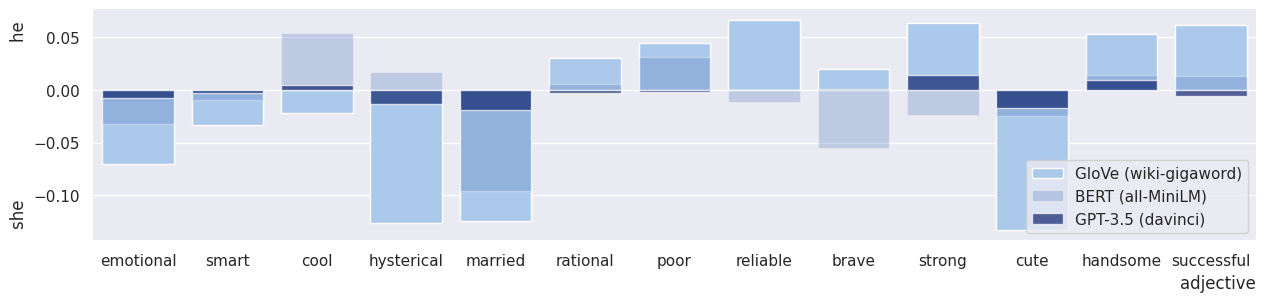

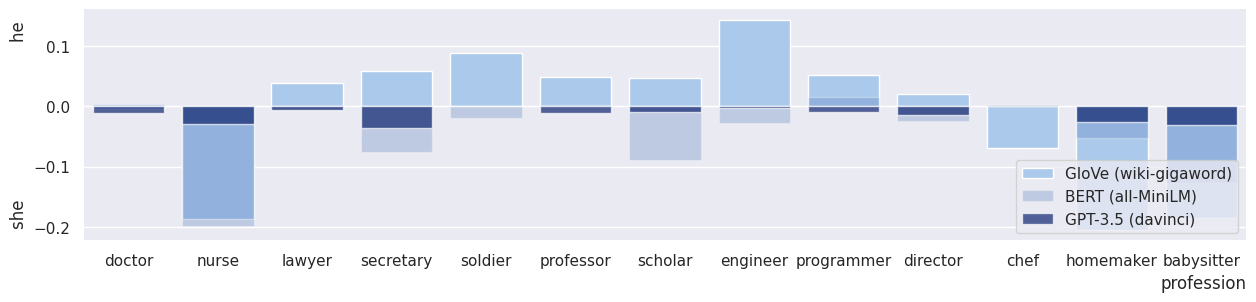

In [10]:
for k_w, words in words_dt.items():
  plt.figure(figsize=(15,3))
  sns.set_color_codes('pastel')
  sns.barplot(x = 'word', y = 'result', data = glv[k_w], label = 'GloVe (wiki-gigaword)', color = 'b', edgecolor = 'w')
  sns.set_color_codes('muted')
  sns.barplot(x = 'word', y = 'result', data = bert[k_w], label = 'BERT (all-MiniLM)', color = 'b', edgecolor = 'w', alpha = 0.3)
  sns.set_color_codes('dark')
  sns.barplot(x = 'word', y = 'result', data = gpt[k_w], label = 'GPT-3.5 (davinci)', color = 'b', edgecolor = 'w', alpha = 0.7)
  sns.despine(left = True, bottom = True)  
  plt.xlabel(k_w, loc='right')
  plt.ylabel('she' + ' '*30 + 'he' )
  plt.legend(ncol = 1, loc = 'lower right')
  plt.show()